### Import resources

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_cnn = pd.read_csv("data/training.csv")
test_cnn = pd.read_csv("data/test.csv")

## Preprocess Data

In [3]:
train_cnn.dropna(inplace=True)
train_cnn.shape

(2140, 31)

In [4]:
from joblib import Parallel, delayed

def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96,96)

with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    x = ex(delayed(format_img)(e) for e in train_cnn.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test = ex(delayed(format_img)(e) for e in test_cnn.Image)
test = np.stack(test)[..., None]
x = np.stack(x)[..., None]
x.shape, test.shape

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    4.3s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:    7.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:    6.3s finished


((2140, 96, 96, 1), (1783, 96, 96, 1))

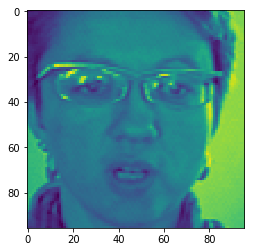

In [5]:
plt.imshow(x[10,:,:,0])

In [6]:
y = train_cnn.iloc[:, :-1].values
y.shape

(2140, 30)

### Visualize a random image from the Data

In [7]:
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color='red')
        
    plt.axis('off')

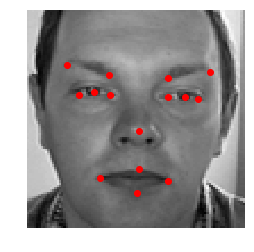

In [8]:
sample_idx = np.random.choice(len(x))    
show(x[sample_idx], y[sample_idx])

### Train validation split

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_val.shape

((1712, 96, 96, 1), (428, 96, 96, 1))

In [10]:
x[:,9,9,0]

array([114, 173, 163, ...,  81,   9,  19], dtype=uint8)

### Normalization

In [11]:
x_train=(x_train/255)
x_val=(x_val/255)
test=(test/255)

### First we'll use ResNet 50 trained with images of ImageNet
###### They will be preprocessed according to resnet preprocessing

In [12]:
from keras.applications.resnet50 import ResNet50, preprocess_input

Using TensorFlow backend.


### Model

In [13]:
test.shape

(1783, 96, 96, 1)

In [14]:
test=np.array([test[:,:,:,0],test[:,:,:,0],test[:,:,:,0]])
test=np.swapaxes(test,0,1)
test=np.swapaxes(test,1,2)
test=np.swapaxes(test,2,3)
test.shape

(1783, 96, 96, 3)

In [15]:
x_train[:,:,:,0].shape
x_train=np.array([x_train[:,:,:,0],x_train[:,:,:,0],x_train[:,:,:,0]])
x_train.shape

(3, 1712, 96, 96)

In [16]:
x_val[:,:,:,0].shape
x_val=np.array([x_val[:,:,:,0],x_val[:,:,:,0],x_val[:,:,:,0]])
x_val.shape

(3, 428, 96, 96)

In [17]:
x_train=np.swapaxes(x_train,0,1)
x_train=np.swapaxes(x_train,1,2)
x_train=np.swapaxes(x_train,2,3)
x_train.shape

(1712, 96, 96, 3)

In [18]:
x_val=np.swapaxes(x_val,0,1)
x_val=np.swapaxes(x_val,1,2)
x_val=np.swapaxes(x_val,2,3)
x_val.shape

(428, 96, 96, 3)

In [19]:
base_model = ResNet50(include_top=False, input_shape=(96,96,3), pooling='avg')
base_model.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [20]:
y.shape

(2140, 30)

In [21]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten,BatchNormalization, Dropout
from keras.optimizers import Adam
from keras import regularizers

top_model = Sequential([
    Dense(512, activation='relu', input_shape=(2048,),kernel_initializer='he_normal'),
    Dense(256, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(96, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dropout(0.7),
    Dense(48, activation='relu',kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_normal'),
    Dense(30)
])
top_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 96)                12384     
_________________________________________________________________
dropout_3 (Dropout)          (None, 96)                0         
__________

## The final model consists of the convolutional resnet layer and the dense layer.

In [22]:
final_model = Sequential([base_model, top_model])
final_model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 30)                1231822   
Total params: 24,819,534
Trainable params: 1,231,822
Non-trainable params: 23,587,712
_________________________________________________________________


# Train the neural network
#### Pre compute the weights of the convolutional layer

In [23]:
precomputed_train = base_model.predict(x_train, batch_size=256, verbose=1)
precomputed_train.shape

1712/1712 [==============================] - 492s 287ms/step


(1712, 2048)

In [24]:
precomputed_val = base_model.predict(x_val, batch_size=256, verbose=1)
precomputed_val.shape

428/428 [==============================] - 115s 269ms/step


(428, 2048)

In [25]:
log = top_model.fit(precomputed_train, y_train, epochs=600, batch_size=256, validation_data=[precomputed_val, y_val])

Train on 1712 samples, validate on 428 samples
Epoch 1/600
1712/1712 [==============================] - 2s 1ms/step - loss: 2557.1981 - mean_absolute_error: 47.0322 - val_loss: 2465.7270 - val_mean_absolute_error: 46.1859
Epoch 2/600
1712/1712 [==============================] - 0s 256us/step - loss: 2128.4736 - mean_absolute_error: 41.6156 - val_loss: 1725.1975 - val_mean_absolute_error: 37.7085
Epoch 3/600
1712/1712 [==============================] - 0s 269us/step - loss: 1583.0811 - mean_absolute_error: 32.8225 - val_loss: 1139.1831 - val_mean_absolute_error: 29.1387
Epoch 4/600
1712/1712 [==============================] - 0s 265us/step - loss: 1176.0993 - mean_absolute_error: 28.2269 - val_loss: 1151.9135 - val_mean_absolute_error: 30.2079
Epoch 5/600
1712/1712 [==============================] - 0s 264us/step - loss: 907.4858 - mean_absolute_error: 24.4966 - val_loss: 679.5754 - val_mean_absolute_error: 22.4221
Epoch 6/600
1712/1712 [==============================] - 0s 274us/step -

1712/1712 [==============================] - 0s 256us/step - loss: 104.7849 - mean_absolute_error: 7.5550 - val_loss: 25.7050 - val_mean_absolute_error: 3.7424
Epoch 95/600
1712/1712 [==============================] - 0s 262us/step - loss: 111.5383 - mean_absolute_error: 7.7767 - val_loss: 31.0243 - val_mean_absolute_error: 4.2751
Epoch 96/600
1712/1712 [==============================] - 0s 256us/step - loss: 108.2031 - mean_absolute_error: 7.6998 - val_loss: 27.1841 - val_mean_absolute_error: 3.8953
Epoch 97/600
1712/1712 [==============================] - 0s 258us/step - loss: 102.1055 - mean_absolute_error: 7.4902 - val_loss: 21.7789 - val_mean_absolute_error: 3.3092
Epoch 98/600
1712/1712 [==============================] - 0s 256us/step - loss: 100.8918 - mean_absolute_error: 7.4043 - val_loss: 25.9062 - val_mean_absolute_error: 3.7682
Epoch 99/600
1712/1712 [==============================] - 0s 262us/step - loss: 104.7756 - mean_absolute_error: 7.5689 - val_loss: 29.9515 - val_mea

1712/1712 [==============================] - 0s 265us/step - loss: 75.9533 - mean_absolute_error: 6.4176 - val_loss: 21.9105 - val_mean_absolute_error: 3.3761
Epoch 189/600
1712/1712 [==============================] - 1s 294us/step - loss: 74.0487 - mean_absolute_error: 6.3351 - val_loss: 19.5762 - val_mean_absolute_error: 3.0965
Epoch 190/600
1712/1712 [==============================] - 1s 322us/step - loss: 74.4714 - mean_absolute_error: 6.3237 - val_loss: 24.4523 - val_mean_absolute_error: 3.6676
Epoch 191/600
1712/1712 [==============================] - 1s 397us/step - loss: 77.9709 - mean_absolute_error: 6.5057 - val_loss: 20.3414 - val_mean_absolute_error: 3.1916
Epoch 192/600
1712/1712 [==============================] - 1s 392us/step - loss: 72.8814 - mean_absolute_error: 6.2309 - val_loss: 20.8186 - val_mean_absolute_error: 3.2484
Epoch 193/600
1712/1712 [==============================] - 1s 329us/step - loss: 77.6699 - mean_absolute_error: 6.4801 - val_loss: 21.5384 - val_mean

1712/1712 [==============================] - 0s 265us/step - loss: 52.9142 - mean_absolute_error: 5.2899 - val_loss: 16.6171 - val_mean_absolute_error: 2.7724
Epoch 283/600
1712/1712 [==============================] - 0s 256us/step - loss: 54.0690 - mean_absolute_error: 5.3433 - val_loss: 17.2810 - val_mean_absolute_error: 2.8640
Epoch 284/600
1712/1712 [==============================] - 0s 268us/step - loss: 52.3021 - mean_absolute_error: 5.2735 - val_loss: 16.1414 - val_mean_absolute_error: 2.7080
Epoch 285/600
1712/1712 [==============================] - 0s 246us/step - loss: 51.9997 - mean_absolute_error: 5.2528 - val_loss: 17.6188 - val_mean_absolute_error: 2.9068
Epoch 286/600
1712/1712 [==============================] - 0s 260us/step - loss: 48.5468 - mean_absolute_error: 5.0358 - val_loss: 16.1705 - val_mean_absolute_error: 2.7112
Epoch 287/600
1712/1712 [==============================] - 0s 256us/step - loss: 51.4368 - mean_absolute_error: 5.2439 - val_loss: 17.8247 - val_mean

1712/1712 [==============================] - 1s 386us/step - loss: 35.2308 - mean_absolute_error: 4.2233 - val_loss: 15.1851 - val_mean_absolute_error: 2.6268
Epoch 377/600
1712/1712 [==============================] - 1s 387us/step - loss: 34.9213 - mean_absolute_error: 4.2300 - val_loss: 15.1898 - val_mean_absolute_error: 2.6264
Epoch 378/600
1712/1712 [==============================] - 1s 360us/step - loss: 34.8002 - mean_absolute_error: 4.1874 - val_loss: 15.1304 - val_mean_absolute_error: 2.6202
Epoch 379/600
1712/1712 [==============================] - 1s 303us/step - loss: 35.1968 - mean_absolute_error: 4.2368 - val_loss: 15.8996 - val_mean_absolute_error: 2.7261
Epoch 380/600
1712/1712 [==============================] - 0s 259us/step - loss: 35.0630 - mean_absolute_error: 4.2470 - val_loss: 14.3608 - val_mean_absolute_error: 2.5115
Epoch 381/600
1712/1712 [==============================] - 0s 253us/step - loss: 34.6187 - mean_absolute_error: 4.1979 - val_loss: 15.2825 - val_mean

1712/1712 [==============================] - 0s 266us/step - loss: 19.9160 - mean_absolute_error: 3.1022 - val_loss: 12.3340 - val_mean_absolute_error: 2.2918
Epoch 471/600
1712/1712 [==============================] - 0s 264us/step - loss: 19.8775 - mean_absolute_error: 3.0852 - val_loss: 12.9912 - val_mean_absolute_error: 2.3833
Epoch 472/600
1712/1712 [==============================] - 0s 265us/step - loss: 20.1932 - mean_absolute_error: 3.1067 - val_loss: 12.3825 - val_mean_absolute_error: 2.3016
Epoch 473/600
1712/1712 [==============================] - 0s 255us/step - loss: 19.3707 - mean_absolute_error: 3.0449 - val_loss: 12.8310 - val_mean_absolute_error: 2.3637
Epoch 474/600
1712/1712 [==============================] - 0s 265us/step - loss: 19.1888 - mean_absolute_error: 3.0297 - val_loss: 12.7468 - val_mean_absolute_error: 2.3516
Epoch 475/600
1712/1712 [==============================] - 0s 267us/step - loss: 18.9487 - mean_absolute_error: 3.0119 - val_loss: 12.9693 - val_mean

1712/1712 [==============================] - 1s 297us/step - loss: 13.4780 - mean_absolute_error: 2.4792 - val_loss: 11.6596 - val_mean_absolute_error: 2.2672
Epoch 565/600
1712/1712 [==============================] - 0s 283us/step - loss: 13.4133 - mean_absolute_error: 2.4719 - val_loss: 11.7368 - val_mean_absolute_error: 2.2763
Epoch 566/600
1712/1712 [==============================] - 1s 421us/step - loss: 13.4618 - mean_absolute_error: 2.4760 - val_loss: 11.6672 - val_mean_absolute_error: 2.2688
Epoch 567/600
1712/1712 [==============================] - 1s 410us/step - loss: 13.5416 - mean_absolute_error: 2.4792 - val_loss: 11.7310 - val_mean_absolute_error: 2.2747
Epoch 568/600
1712/1712 [==============================] - 1s 355us/step - loss: 13.4516 - mean_absolute_error: 2.4729 - val_loss: 11.6796 - val_mean_absolute_error: 2.2709
Epoch 569/600
1712/1712 [==============================] - 1s 338us/step - loss: 13.3405 - mean_absolute_error: 2.4658 - val_loss: 11.6945 - val_mean

#### Training loss

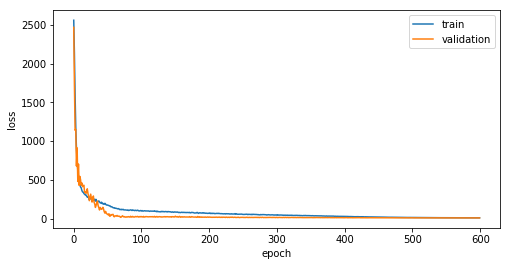

In [26]:
def show_results(*logs):
    trn_loss, val_loss, trn_acc, val_acc = [], [], [], []
    
    for log in logs:
        trn_loss += log.history['loss']
        val_loss += log.history['val_loss']
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(trn_loss, label='train')
    ax.plot(val_loss, label='validation')
    ax.set_xlabel('epoch'); ax.set_ylabel('loss')
    ax.legend()
    
show_results(log)

# Results
##### Function to display results

In [27]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
        
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

In [28]:
x_val[0,None].shape

(1, 96, 96, 3)

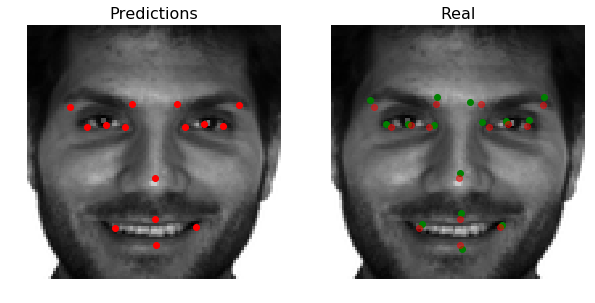

In [29]:
sample_x = x_train[9, None]
sample_y = y_val[9, None]
pred = final_model.predict(sample_x)
show_pred(sample_x, sample_y, pred)

In [30]:
results=final_model.predict(test)
results

array([[66.024254, 36.888332, 29.641697, ..., 72.53157 , 48.003464,
        82.037186],
       [66.36613 , 36.84777 , 29.5854  , ..., 72.79416 , 48.211704,
        82.76775 ],
       [65.849106, 36.91018 , 29.671524, ..., 72.398   , 47.894695,
        81.65929 ],
       ...,
       [66.58533 , 36.821827, 29.549332, ..., 72.962524, 48.345165,
        83.23612 ],
       [66.440315, 36.83899 , 29.573189, ..., 72.851135, 48.25689 ,
        82.92627 ],
       [66.71515 , 36.806335, 29.527863, ..., 73.062126, 48.424404,
        83.51374 ]], dtype=float32)

In [31]:
lookup = pd.read_csv("data/IdLookupTable.csv")

In [32]:
lookid_list = list(lookup['FeatureName'])
imageID = list(lookup['ImageId']-1)
pre_list = list(results)

rowid = lookup['RowId']
rowid=list(rowid)
len(rowid)

feature = []
for f in list(lookup['FeatureName']):
    feature.append(lookid_list.index(f))
    preded = []
for x,y in zip(imageID,feature):
    preded.append(results[x][y])

In [33]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('submission_resnet.csv',index = False)